In [2]:
import numpy as np
import pandas as pd
import os


In [3]:
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
model = keras.Sequential([
                          layers.Dense(16,activation='relu'),
                          layers.Dense(1),
])
wider = keras.Sequential([
                          layers.Dense(32,activation='relu'),
                          layers.Dense(1),
])
deeper = keras.Sequential([
                          layers.Dense(16,activation='relu'),
                          layers.Dense(16,activation='relu'),
                          layers.Dense(1),
])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

In [8]:
data = pd.read_csv('winequality-red.csv')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer,make_column_selector
from sklearn.model_selection import train_test_split

In [10]:
X = data.values
X_train, X_test = train_test_split(X, test_size=0.2, random_state=27)
print(X_train.shape, X_test.shape)

(1279, 12) (320, 12)


In [15]:
df_train = data.sample(frac=0.7,random_state=27)
df_valid = df_train.drop(df_train.index)

In [16]:
max_ = df_train.max(axis=0)
min_ = df_train.min(axis=0)
df_train = (df_train - min_) / (max_ - min_)
df_valid = (df_valid - min_) / (max_ - min_)

In [17]:
X_train = df_train.drop('quality', axis = 1)
X_valid = df_valid.drop('quality', axis = 1)
y_train = df_train['quality']
y_valid = df_valid['quality']

In [18]:
from tensorflow.keras import callbacks

In [19]:
modelRW = keras.Sequential([
                 layers.Dense(512,activation='relu',input_shape=[11]),
                 layers.Dense(512,activation='relu'),
                 layers.Dense(512,activation='relu'),
                 layers.Dense(1),           
])

In [20]:
modelRW.compile(
    optimizer = 'adam',
    loss = 'mae',
)

In [21]:
history = modelRW.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0,
)

In [24]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot();
print('min valid loss:{}'.format(history_df['val_loss'].min()))

KeyError: ignored

In [25]:
fileN='/content/drive/MyDrive/Colab Notebooks/data/spotify.zip'

In [28]:
!unzip 'spotify.zip'

Archive:  spotify.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of spotify.zip or
        spotify.zip.zip, and cannot find spotify.zip.ZIP, period.


In [30]:
from sklearn.model_selection import GroupShuffleSplit

In [31]:
spotify = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/spotify.csv')
spotify.head()

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.748,0.916,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.726,0.815,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.675,0.931,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.718,0.930,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,dance pop,0.650,0.833,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


In [38]:
X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']
features_num = ['danceability','energy','key','loudness','mode',
                'speechiness','acousticness','instrumentalness',
                'liveness','valence','tempo','duration_ms']
features_cat = ['playlist_genre']

In [39]:
artists

0              Ed Sheeran
1                Maroon 5
2            Zara Larsson
3        The Chainsmokers
4           Lewis Capaldi
               ...       
32828        Lush & Simon
32829      Tegan and Sara
32830         Starkillers
32831              Mat Zo
32832        Julian Calor
Name: track_artist, Length: 32828, dtype: object

In [40]:
preprocessor = make_column_transformer(
    (StandardScaler(),features_num),
    (OneHotEncoder(),features_cat),
)

In [41]:
def group_split(x,y,group,train_size=0.75):
  splitter = GroupShuffleSplit(train_size=train_size)
  print(splitter.get_n_splits())
  train,test = next(splitter.split(X,y,groups=group))
  return (X.iloc[train],X.iloc[test],y.iloc[train],y.iloc[test])

In [42]:
X_train,X_valid,y_train,y_valid = group_split(X,y,artists)

5


In [43]:
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.fit_transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

In [45]:
input_shape = [X_train.shape[1]]
input_shape

[18]

In [46]:
model = keras.Sequential([
                          layers.Dense(1,input_shape=input_shape),
])

In [47]:
model.compile(
    optimizer='adam',
    loss='mae',
)

In [48]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

min valid loss:0.19920848309993744


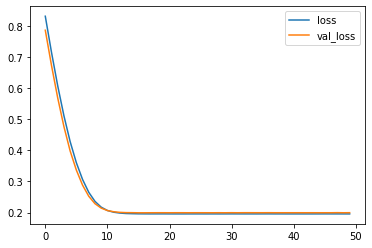

In [49]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:,['loss','val_loss']].plot();
print('min valid loss:{}'.format(history_df['val_loss'].min()))

min valid loss:0.19920848309993744


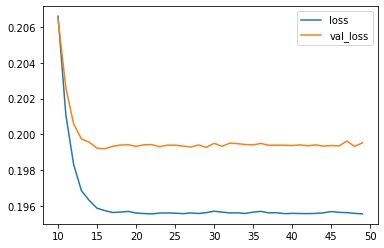

In [50]:
history_df.loc[10:,['loss','val_loss']].plot();
print('min valid loss:{}'.format(history_df['val_loss'].min()))

In [51]:
model1 = keras.Sequential([
                          layers.Dense(128, activation='relu', input_shape=input_shape),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(1),
])

In [52]:
model1.compile(
    optimizer='adam',
    loss='mae',
)

In [53]:
history1 = model1.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

min valid loss:0.19920848309993744


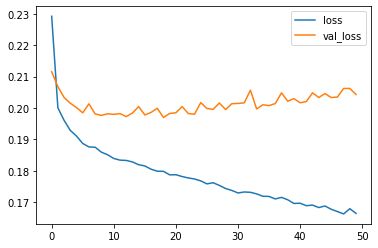

In [54]:
history_df1 = pd.DataFrame(history1.history)
history_df1.loc[0:,['loss','val_loss']].plot();
print('min valid loss:{}'.format(history_df['val_loss'].min()))

In [55]:
early_stopping = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True,
)

In [59]:
history2 = model1.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,
)

min valid loss:0.19920848309993744


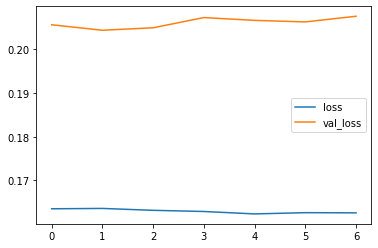

In [60]:
history_df2 = pd.DataFrame(history2.history)
history_df2.loc[0:,['loss','val_loss']].plot();
print('min valid loss:{}'.format(history_df['val_loss'].min()))

In [61]:
model1 = keras.Sequential([
                          layers.Dense(256, activation='relu', input_shape=input_shape),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(1),
])

In [62]:
model2 = keras.Sequential([
                          layers.Dense(128, activation='relu', input_shape=input_shape),
                           layers.Dense(128, activation='relu'),
                            layers.Dense(64, activation='relu'),
                           layers.Dense(1),
])

In [64]:
model3 = keras.Sequential([
                          layers.Dense(256, activation='relu', input_shape=input_shape),
                           layers.Dense(128, activation='relu'),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(1),
])

In [65]:
model1.compile(optimizer='adam',loss='mae',)
model2.compile(optimizer='adam',loss='mae',)
model3.compile(optimizer='adam',loss='mae',)

In [66]:
history1 = model1.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,
)

In [67]:
history2 = model2.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,
)

In [68]:
history3 = model3.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,
)

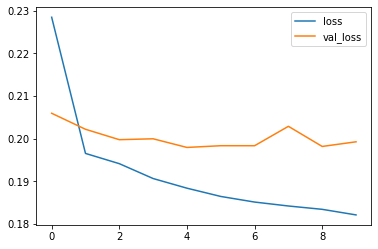

In [69]:
history_df1 = pd.DataFrame(history1.history)
history_df1.loc[0:,['loss','val_loss']].plot();

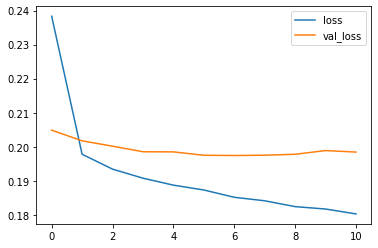

In [70]:
history_df2 = pd.DataFrame(history2.history)
history_df2.loc[0:,['loss','val_loss']].plot();

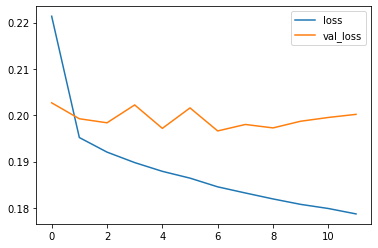

In [71]:
history_df3 = pd.DataFrame(history3.history)
history_df3.loc[0:,['loss','val_loss']].plot();